Configure Google Colab env

In [ ]:
!pip install mne

In [ ]:
%cd drive/MyDrive/Datasets/Iteration_1/
% ls

In [ ]:
from google.colab import files
files.upload()

In [4]:
import numpy as np
import mne
import pandas as pd
import os
import csv
from math import floor, ceil
import pickle

from tensorflow.keras import utils as np_utils
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# EEGNet-specific imports
from EEGModels_test import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
import seaborn as sns 

K.set_image_data_format('channels_last')

# Load and process data

In [7]:
# constants for processing

eeg_epochs_set_dir_name = "Epochs_set_fdt"
eeg_epochs_set_dir = os.path.join(os.getcwd(), eeg_epochs_set_dir_name)
filenames_eeg_set = [f for f in os.listdir(eeg_epochs_set_dir) if f.endswith('.set')]

eeg_epochs_csv_dir_name = "EEG_epochs_csv"
eeg_epochs_csv_dir = os.path.join(os.getcwd(), eeg_epochs_csv_dir_name)

kernels, chans, samples = 1, 30, 1500

In [ ]:
% cd Epochs_set_fdt

In [ ]:
# load all EEG epochs data, as X input for EEGNet

X_list = []
for f in filenames_eeg_set:
  
  file_epochs = mne.io.read_epochs_eeglab(f, verbose=0)
  X_list.append(file_epochs.get_data()*1000)
  
X = np.vstack(X_list)
X_list = []

print(f"Input shape: {X.shape}")

In [11]:
%cd ..

/content/drive/MyDrive/Datasets/Iteration_1
EEG_epochs_csv/     labels_median.csv              X_validate_4442_median.pkl
EEGModels.py        __pycache__/                   Y_test_4442_median.pkl
EEGModels_test.py   X_1582_2classes_epochs_id.pkl  Y_train_4442_median.pkl
Epochs_set_fdt/     X_1582_2classes.pkl            Y_validate_4442_median.pkl
Events/             X_test_4442_median.pkl
labels_by_time.csv  X_train_4442_median.pkl


In [12]:
# load labels as y input for EEGNet

y = pd.read_csv("labels_by_time.csv")
y['label'] = y['label'].fillna("other")
labels_mapping = {"attentive": 0, "inattentive": 1, "other": 2}
y = y.replace({"label": labels_mapping})
y.rename(columns={'Unnamed: 0': 'orig_idx'}, inplace=True)
y_attentive = y[y['label']==0]
y_inattentive = y[y['label']==1]
y_attentive = y_attentive.sample(n=791, random_state=0)
y = pd.concat([y_attentive, y_inattentive])
y = y.sort_values(by='orig_idx')

print(y)
print(y['label'].value_counts())

      orig_idx  time_between  label
8            8         3.524      1
12          12         5.684      1
15          15         4.380      1
17          17         4.316      1
18          18         6.468      1
...        ...           ...    ...
4431      4431         0.652      0
4434      4434         0.536      0
4436      4436         0.068      0
4437      4437         0.700      0
4439      4439         0.620      0

[1582 rows x 3 columns]
1    791
0    791
Name: label, dtype: int64


In [13]:
# convert labels to array and get their index from original dataset

not_null_index = y['orig_idx'].to_numpy()
y = y['label'].to_numpy()
unique, counts = np.unique(y, return_counts=True)

print(y)

print(np.asarray((unique, counts)).T)

[1 1 1 ... 0 0 0]
[   8   12   15 ... 4436 4437 4439]


In [15]:
# extract samples from original dataset based on index
X_copy_list = []

for i in range(X.shape[0]):
  if i in not_null_index:
    X_copy_list.append(X[i])

print(len(X_copy_list))
print(X_copy_list[0].shape)

X_copy = np.stack(X_copy_list, axis=0)
X_copy_list = []
X_copy.shape

1582
(30, 1500)


(1582, 30, 1500)

In [17]:
# extract subsets
train_subset_idx = ceil(X_copy.shape[0]*0.8)
valid_subset_idx = train_subset_idx + ceil(X_copy.shape[0]*0.1)

X_train      = X_copy[0:train_subset_idx]
Y_train      = y[0:train_subset_idx]
X_validate   = X_copy[train_subset_idx:valid_subset_idx]
Y_validate   = y[train_subset_idx:valid_subset_idx]
X_test       = X_copy[valid_subset_idx:]
Y_test       = y[valid_subset_idx:]

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)

# convert data to NHWC (trials, channels, samples, kernels) format
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

print('Y_train shape:', Y_train.shape)

X_train shape: (1266, 30, 1500, 1)
1266 train samples
159 validate samples
157 test samples
Y_train shape: (1266, 2)


In [ ]:
# load subsets prepared previously for this experiment
# X_train = pickle.load(open("X_train_1266.pkl", "rb"))
# Y_train = pickle.load(open("Y_train_1266.pkl", "rb"))
# X_validate = pickle.load(open("X_validate_159.pkl", "rb"))
# Y_validate = pickle.load(open("Y_validate_159.pkl", "rb"))
# X_test = pickle.load(open("X_test_157.pkl", "rb"))
# Y_test = pickle.load(open("Y_test_157.pkl", "rb"))

# print('X_train shape:', X_train.shape)
# print('Y_train shape:', Y_train.shape)
# print('X_validate shape:', X_validate.shape)
# print('Y_validate shape:', Y_validate.shape)
# print('X_test shape:', X_test.shape)
# print('Y_test shape:', Y_test.shape)

## Model training

In [23]:
# initialize model

model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 32, D = 4, F2 = 32, 
               dropoutType = 'Dropout')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1500, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 1500, 32)      1024      
                                                                 
 batch_normalization_3 (Batc  (None, 30, 1500, 32)     128       
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 1500, 128)     3840      
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 1500, 128)     512       
 hNormalization)                                                 
                                                           

In [21]:
# model compilation and checkpointer
adam = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
class_weights = {0:1, 1:1}

In [22]:
# training
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 60, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer],verbose = 2, class_weight = class_weights)

Epoch 1/60

Epoch 00001: val_loss improved from inf to 0.69341, saving model to /tmp/checkpoint.h5
40/40 - 16s - loss: 0.7029 - accuracy: 0.5118 - val_loss: 0.6934 - val_accuracy: 0.0126 - 16s/epoch - 393ms/step
Epoch 2/60

Epoch 00002: val_loss did not improve from 0.69341
40/40 - 3s - loss: 0.6765 - accuracy: 0.5987 - val_loss: 0.6972 - val_accuracy: 0.0126 - 3s/epoch - 87ms/step
Epoch 3/60

Epoch 00003: val_loss did not improve from 0.69341
40/40 - 3s - loss: 0.6645 - accuracy: 0.6675 - val_loss: 0.7054 - val_accuracy: 0.0126 - 3s/epoch - 87ms/step
Epoch 4/60

Epoch 00004: val_loss did not improve from 0.69341
40/40 - 3s - loss: 0.6446 - accuracy: 0.6904 - val_loss: 0.7205 - val_accuracy: 0.0126 - 3s/epoch - 86ms/step
Epoch 5/60

Epoch 00005: val_loss did not improve from 0.69341
40/40 - 3s - loss: 0.6183 - accuracy: 0.7188 - val_loss: 0.7477 - val_accuracy: 0.0126 - 3s/epoch - 87ms/step
Epoch 6/60

Epoch 00006: val_loss did not improve from 0.69341
40/40 - 3s - loss: 0.5980 - accur

In [25]:
# reload best weights
model.load_weights('/tmp/checkpoint.h5')

In [26]:
# prediction
probs = model.predict(X_test)
preds = probs.argmax(axis = -1)  
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.987261 


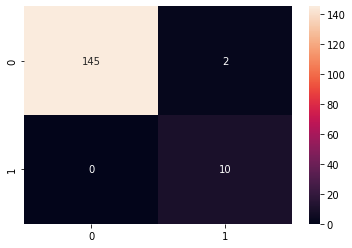

In [27]:
Y_test_decoded = np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_true=Y_test_decoded, y_pred=preds)
sns.heatmap(cm, annot=True, fmt="d")

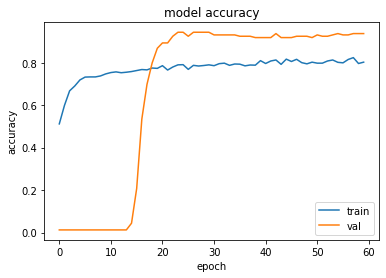

In [28]:
# summarize history for accuracy
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

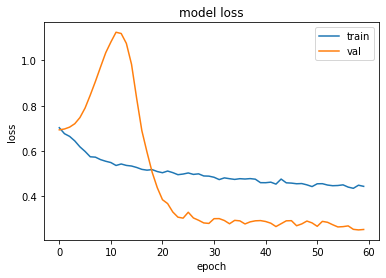

In [29]:
# summarize history for loss
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('test-model')